# Example: Mediation analysis and direct effects

In [23]:
from typing import Dict, List, Optional, Tuple, Union, TypeVar, Callable

import torch
import torch.nn as nn
import pandas as pd

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, PyroParam

import causal_pyro
from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import MultiWorldCounterfactual

## Background: nested counterfactuals



[Direct and indirect effects](https://ftp.cs.ucla.edu/pub/stat_ser/R273-U.pdf)

[Nested counterfactuals](https://proceedings.neurips.cc/paper/2021/hash/36bedb6eb7152f39b16328448942822b-Abstract.html)


Question: What is the direct effect of deviant peer engagement on substance use disorder?

Does reduced engagement with deviant peer groups and reduced experimentation with drugs mediate the effect of the family intervention during adolescence on future substance use disorder?

In the example, we examine the causal chain “Participation in family intervention -> reduced engagement with deviant peer groups and experimentation with drugs -> substance use disorder in young adulthood”.

In other words, we expect that participation in family intervention during adolescence reduces engagement with deviant peer groups and experimentation with drugs, which in turns reduces the likelihood for substance use disorder in young adulthood.

# Data


`"dev_peer"` represents engagement with deviant peer groups and it was coded as “0: No” and “1: Yes”;

`"sub_exp"` represents experimentation with drugs and it was coded as “0: No” and “1: Yes”;

`"fam_int"` represents participation in family intervention during adolescence and it was coded as “0: No” and “1: Yes”;

`"sub_disorder"` represents diagnosis of substance use disorder in young adulthood and it was coded as “0: No: and “1: Yes”.

`"conflict"` represents level of family conflict. It will be used as a covariate in this analysis.

`"gender"` is the gender of the participant.

In [24]:
# Let's load the data from the url
data_url = "https://statsnotebook.io/blog/data_management/example_data/substance.csv"
# data_url = "http://data.mxnet.io/data/personality.csv"

data = pd.read_csv(data_url)
data = data.dropna()  # for now, ignore rows with missing or invalid data

# Show the data
data.head()

,gender,conflict,dev_peer,sub_exp,fam_int,sub_disorder
0,Female,3.000000,1.0,0.0,0.0,0.0
1,Female,3.000000,1.0,1.0,0.0,0.0
2,Male,4.000000,1.0,1.0,0.0,1.0
4,Female,2.666667,1.0,1.0,0.0,0.0
5,Female,2.000000,1.0,1.0,0.0,0.0


## Model

We can represent the causal assumptions discussed above as a Pyro program: 

In [39]:
def abstract_model(f_dev_peer: Callable, f_sub_exp: Callable, f_sub_disorder: Callable):
    # Family intervention is exogenous
    fam_int = pyro.sample("fam_int", dist.Bernoulli(torch.tensor([0.5])).to_event(1))
    logits_dev_peer = f_dev_peer(fam_int)
    dev_peer = pyro.sample("dev_peer", dist.Bernoulli(logits=logits_dev_peer).to_event(1))
    logits_sub_exp = f_sub_exp(fam_int)
    sub_exp = pyro.sample("sub_exp", dist.Bernoulli(logits=logits_sub_exp).to_event(1))
    logits_sub_disorder = f_sub_disorder(dev_peer, sub_exp)
    sub_disorder = pyro.sample("sub_disorder", dist.Bernoulli(logits=logits_sub_disorder).to_event(1))
    return fam_int, dev_peer, sub_exp, sub_disorder

We can use a surrogate causal model with linear functions with learnable parameters to represent the abstract mechanisms:

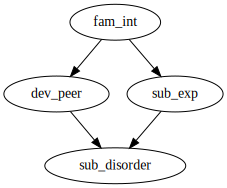

In [40]:
class CausalModel(PyroModule):
    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(1, 1)
        self.lr2 = nn.Linear(1, 1)
        self.lr3 = nn.Bilinear(1, 1, 1)

    def forward(self):
        return abstract_model(self.lr1, self.lr2, self.lr3)

m = CausalModel()
pyro.render_model(m)

## Query: natural direct effect (NDE)

The natural direct effect

$$NDE ( Y; x, x' ) = \mathbb{E} [ Y_{X=x', Z=Z_{X=x}} - \mathbb{E} [ Y_{X=x} ] ]$$

In [41]:
def direct_effect(model: Callable, X: str, Z: str) -> Callable:
    def wrapper(x, x_prime):
        with MultiWorldCounterfactual(-2):
            return do(actions={X: x})(
                do(actions={X: x_prime})(
                    do(actions={Z: lambda Z_: Z_})(
                        model)))()
    return wrapper

We can apply this directly to the causal model defined above to get a new model representing the joint distribution over all factual and counterfactual variables necessary to estimate the NDE:

In [42]:
query_model = direct_effect(m, "fam_int", "sub_exp")
pyro.render_model(query_model, (torch.tensor([0.]), torch.tensor([1.])))

Type of obs:  <class 'pyro.ops.provenance.ProvenanceTensor'>
Type of act:  <class 'torch.Tensor'>
Type of obs:  <class 'pyro.ops.provenance.ProvenanceTensor'>
Type of act:  <class 'torch.Tensor'>
Type of obs:  <class 'pyro.ops.provenance.ProvenanceTensor'>
Type of act:  <class 'function'>


RuntimeError: bilinear(): input dimensions do not match: got 4 and 5
           Trace Shapes:          
            Param Sites:          
            lr1$$$weight     1 1  
              lr1$$$bias       1  
            lr2$$$weight     1 1  
              lr2$$$bias       1  
            lr3$$$weight     1 2  
              lr3$$$bias       1  
           Sample Sites:          
            fam_int dist       | 1
                   value       | 1
     intervention_2 dist       |  
                   value     2 |  
     intervention_3 dist       |  
                   value     2 |  
  dev_peer_observed dist 2 2 1 | 1
                   value 2 2 1 | 1
dev_peer_unobserved dist 2 2 1 | 1
                   value 2 2 1 | 1
   sub_exp_observed dist 2 2 1 | 1
                   value 2 2 1 | 1
 sub_exp_unobserved dist 2 2 1 | 1
                   value 2 2 1 | 1
     intervention_4 dist       |  
                   value     2 |  

A quantity complementary to the direct effect is the indirect effect:

$$IE ( Y; x, x' ) = \mathbb{E} [ Y_{X=x', Z=Z_{X=x}} - \mathbb{E} [ Y_{X=x} ] ]$$

Interestingly, the indirect effect is also computable from the same query operation under `MultiWorldCounterfactual`.

# Inference

Before attempting to compute the natural direct effect, we first learn the model's parameters.

In [38]:
conditioned_model = pyro.condition(data={
    "fam_int": torch.tensor(data["fam_int"].values, dtype=torch.float)[..., None],
    "dev_peer": torch.tensor(data["dev_peer"].values, dtype=torch.float)[..., None],
    "sub_exp": torch.tensor(data["sub_exp"].values, dtype=torch.float)[..., None],
    "sub_disorder": torch.tensor(data["sub_disorder"].values, dtype=torch.float)[..., None],
})(
    pyro.plate("data", len(data), dim=-1)(
        m
    )
)

pyro.render_model(conditioned_model)

RuntimeError: mat1 and mat2 must have the same dtype
Trace Shapes:          
 Param Sites:          
 lr1$$$weight       1 1
   lr1$$$bias         1
 lr2$$$weight       1 1
   lr2$$$bias         1
 lr3$$$weight       1 2
   lr3$$$bias         1
Sample Sites:          
 fam_int dist     410 |
        value 410   1 |

In [ ]:
guide = pyro.infer.autoguide.AutoDelta(conditioned_model)
adam = pyro.optim.Adam({"lr": 0.03})
svi = pyro.infer.SVI(conditioned_model, guide, adam, loss=pyro.infer.Trace_ELBO())
num_iterations = 100
for j in range(num_iterations):
    loss = svi.step()
    if j % 10 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

Now we can use the expanded model defined previously to get the natural direct effect:

In [ ]:
query_guide = pyro.infer.autoguide.AutoDelta(query_model)
query_adam = pyro.optim.Adam({"lr": 0.03})
query_svi = pyro.infer.SVI(query_model, query_guide, query_adam, loss=pyro.infer.Trace_ELBO())
num_iterations = 100
for j in range(num_iterations):
    loss = query_svi.step()
    if j % 10 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

# Evaluation

We can compute the natural direct effect from samples of the posterior distribution over the potential outcomes: